In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random
import os

# 재현성 함수
def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 42 # 시드값

device = 'cuda' if torch.cuda.is_available() else 'cpu' # 장치 문자열
device

'cuda'

- 이미지 파일 코랩 세션디렉토리에 복사및 압축푸는 명령어

In [ ]:
!cp "{DATA_PATH}cats_and_dogs.zip" "cats_and_dogs.zip"
!unzip -oqq "cats_and_dogs.zip"

In [7]:
from glob import glob
import os

# 데이터 경로를 직접 설정합니다.
DATA_PATH = r"C:\\study\\03_Deep_Learning\\data\\cats_and_dogs"  # 경로 수정

# 고양이 이미지 파일 경로를 담은 리스트
cats_list = sorted(glob(os.path.join(DATA_PATH, "train/cats/*.jpg")), key=lambda x: x)

# 개 이미지 파일 경로를 담은 리스트
dogs_list = sorted(glob(os.path.join(DATA_PATH, "train/dogs/*.jpg")), key=lambda x: x)

# 각 리스트의 길이를 출력합니다.
len(cats_list), len(dogs_list)


(1000, 1000)

- 고양이: 0,  개: 1

In [8]:
labels = [0] * len(cats_list) + [1] * len(dogs_list) # 정답데이터 만들기
img_path = cats_list + dogs_list # 고양이와 개 이미지 파일 경로 합치기

len(labels), len(img_path)

(2000, 2000)

- 섞기

In [9]:
# 멀티 인덱싱을 위해 ndarray 로 변환
train = np.array(img_path)
target = np.array(labels)

np.random.seed(SEED) # 동일한 shuffle 위해 시드 고정

# 인덱스를 이용하여 섞기 위해 샘플 개수 만큼 인덱스 생성
index_arr = np.arange(train.shape[0])

# 섞기
np.random.shuffle(index_arr)
np.random.shuffle(index_arr)

# shuffle 된 인덱스를 이용하여 샘플 섞기
train = train[index_arr]
target = target[index_arr]

In [10]:
img_path = train[0]
img_path

'C:\\\\study\\\\03_Deep_Learning\\\\data\\\\cats_and_dogs\\train/dogs\\dog.900.jpg'

In [11]:
import cv2

image = cv2.imread(img_path) # BGR 채널 순서로 로딩
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB 채널 순서로 변경

# albumentations 라이브러리
- torchvision.transforms 에도 자주 쓰이는 이미지 변환 기법들이 구현되어 있고, 처리속도가 더 빠르다.

```shell
pip install albumentations
```

In [12]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

C:\Users\hopio\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## ToTensorV2
- 차원 순서를 C, H, W 순서로 변경후 텐서로 반환
- 입력으로 ndarray 전달해줘야 한다.
- 스케일링을 안 해줌

In [13]:
aug = ToTensorV2()
aug(image = image) # 키워드 아규먼트 전달 방식으로 ndarray 전달해야 함, 반환 되는 데이터는 딕셔너리와 비슷한 객체

{'image': tensor([[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],
 
         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]],
 
         [[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)}

In [14]:
aug(image = image)['image'].shape

torch.Size([3, 500, 460])

## Normalize
- 스케일링 및 정규화까지 해줌.
- mean
    - 정규화시 각채널에 사용할 평균값
    - 기본값: (0.485, 0.456, 0.406)
- std
    - 정규화시 각채널에 사용할 표준편차값
    - 기본값: (0.229, 0.224, 0.225)

In [15]:
aug = A.Normalize()
aug(image=image)["image"]

array([[[2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        ...,
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999]],

       [[2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        ...,
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999]],

       [[2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        ...,
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999]],

       ...,

       [[2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        [2.2489083, 2.4285712, 2.6399999],
        ...,
        [2.2489083, 2.4285

In [16]:
# 스케일링만 하려면?
aug = A.Normalize(mean=0, std=1)
aug(image=image)["image"]

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]], dtype=float32)

In [17]:
import matplotlib.pyplot as plt

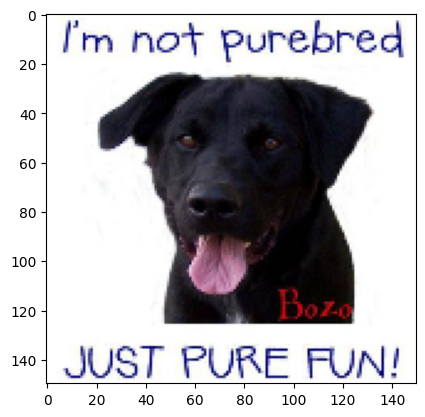

In [18]:
aug = A.Resize(150, 150) # h, w
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## HorizontalFlip
- 좌우반전

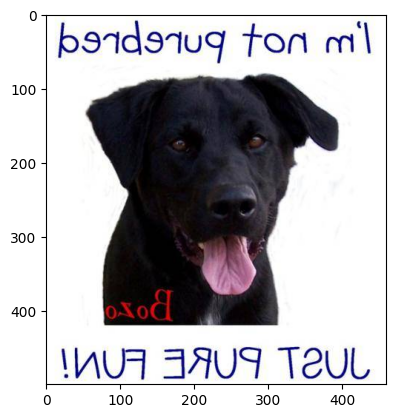

In [20]:
aug = A.HorizontalFlip(p=1)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## VerticalFlip
- 상하반전

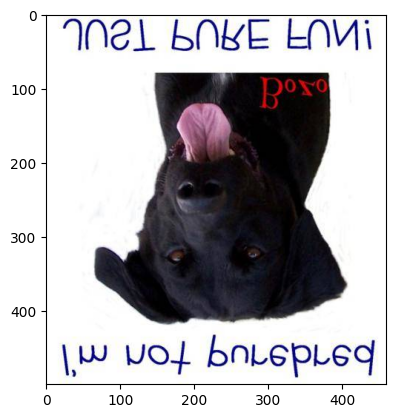

In [21]:
aug = A.VerticalFlip(p=1)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## ToGray
- 흑백이미지로 변환

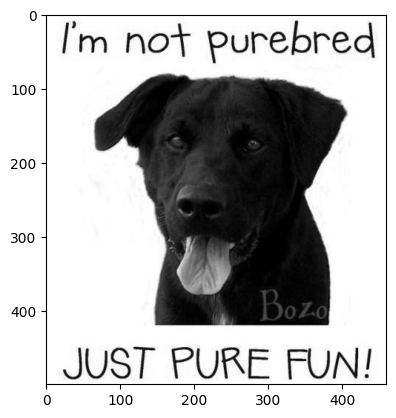

In [22]:
aug = A.ToGray(p=1)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## Perspective
- 원근 변환

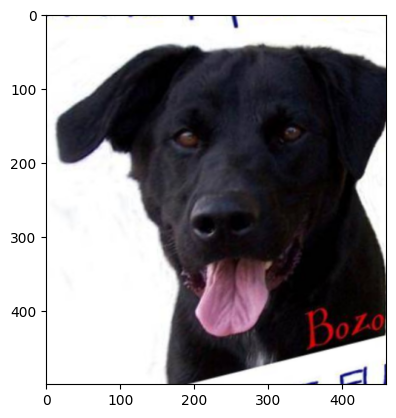

In [23]:
aug = A.Perspective(p=1)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## InvertImg
- 색상반전

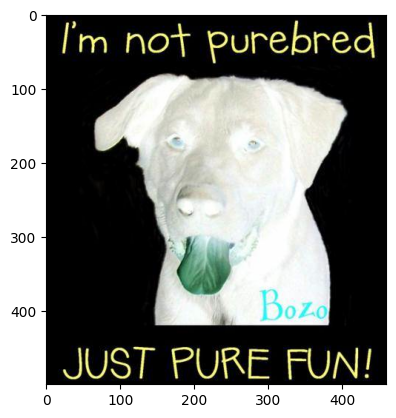

In [24]:
aug = A.InvertImg(p=1)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## Posterize
- 포스터화

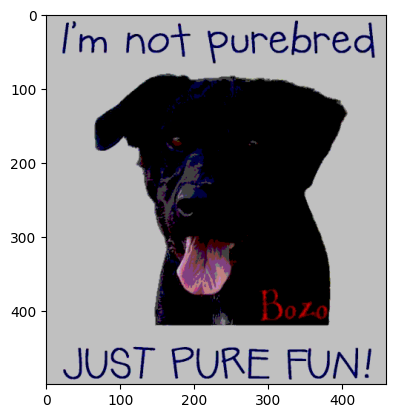

In [25]:
aug = A.Posterize(p=1, num_bits=2)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## Equalize
- 이미지 히스토그램 균등화

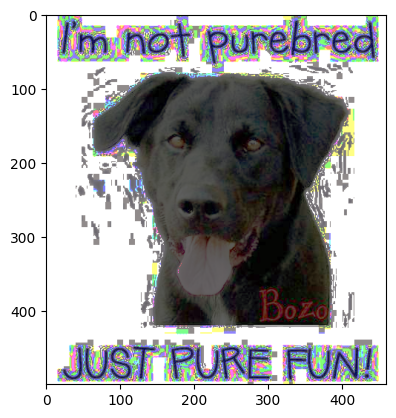

In [26]:
aug = A.Equalize(p=1)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## CenterCrop
- 지정한 사이즈로 center crop

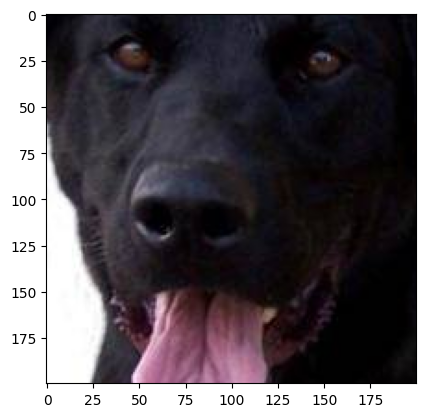

In [27]:
aug = A.CenterCrop(200, 200, p=1)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## RandomResizedCrop
- 랜덤으로 crop 후 지정된 사이즈로 리사이징

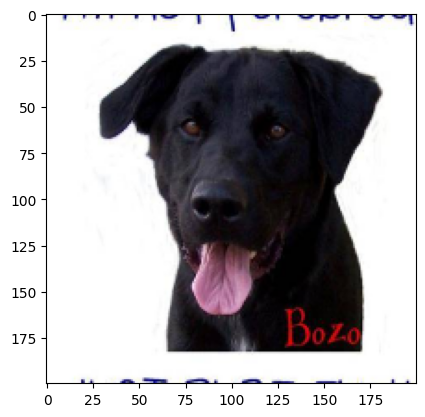

In [28]:
aug = A.RandomResizedCrop(200, 200, p=1)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## Affine
- 아핀 변환

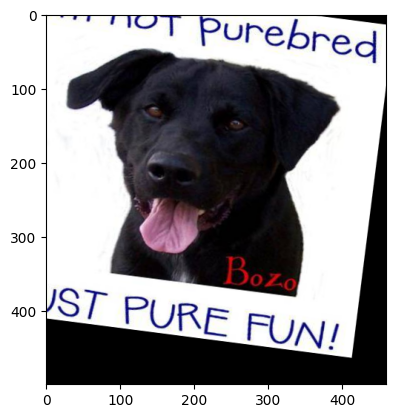

In [29]:
aug = A.Affine(p=1)
tmp = aug(image=image)["image"]
plt.imshow(tmp)
plt.show()

## Compose

In [30]:
lst = [
    A.Resize(150,150), # 리사이징
    A.VerticalFlip(p=0.5), # 상하반전
    A.Normalize(), # 스케일링 후 정규화
    ToTensorV2() # C, H, W  차원 순서의 텐서로 변환
]
transform = A.Compose(lst)
transform(image=image)["image"].shape

torch.Size([3, 150, 150])

- 정답데이터 2차원 형태로 변경

In [31]:
target = target.reshape(-1, 1)
target.shape

(2000, 1)

# 학습및 테스트용 트랜스폼 객체 만들기

In [32]:
lst = [
    A.Resize(224,224),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Affine(p=0.3),
    A.Normalize(),
    ToTensorV2()
]

train_transform = A.Compose(lst) # 학습용 변환 객체


lst = [
    A.Resize(224,224),
    A.Normalize(),
    ToTensorV2()
]

test_transform = A.Compose(lst) # 테스트 또는 검증용 변환 객체

# 데이터셋 클래스

In [33]:
class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, transform, x, y=None):
        self.transform = transform
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        item = {}
        x = cv2.imread( self.x[idx] ) # BGR 순서의 ndarray 가 반환
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) # RGB 순서로 변경
        item["x"] = self.transform(image = x)["image"] # 키워드 아규먼트 형식으로 전달후 image 키에 접근해서 텐서 반환
        if self.y is not None: # 정답데이터가 있다면
            item["y"] = torch.Tensor( self.y[idx] )

        return item

In [34]:
dt = CatDogDataset(train_transform, train, target)
dl = torch.utils.data.DataLoader(dt, batch_size = 2, shuffle=True)
batch = next(iter(dl))
batch

{'x': tensor([[[[ 0.6563,  0.6563,  0.6563,  ...,  0.9132,  0.7077,  1.0331],
           [ 0.1254,  0.1254,  0.1254,  ..., -0.6965, -0.7993, -0.3883],
           [ 0.1939,  0.1939,  0.1939,  ..., -0.6281, -0.7993, -0.3712],
           ...,
           [-0.9192, -0.9192, -0.8164,  ..., -1.1589, -1.3130, -0.7650],
           [-0.9192, -0.9363, -0.7993,  ..., -1.1760, -1.3130, -0.7822],
           [-0.9192, -0.8849, -0.7993,  ..., -1.1760, -1.3130, -0.7822]],
 
          [[ 0.5203,  0.5203,  0.5203,  ...,  0.7829,  0.6779,  1.0630],
           [-0.1099, -0.1099, -0.1099,  ..., -0.9328, -0.9328, -0.4426],
           [-0.1625, -0.1625, -0.1625,  ..., -0.9503, -0.9853, -0.4951],
           ...,
           [-0.7402, -0.8102, -0.8277,  ..., -1.4405, -1.4930, -0.8978],
           [-0.7227, -0.7927, -0.8277,  ..., -1.4580, -1.5105, -0.9153],
           [-0.7052, -0.7577, -0.7752,  ..., -1.4580, -1.5105, -0.9153]],
 
          [[ 0.5136,  0.5136,  0.5136,  ...,  0.7751,  0.7751,  1.1759],
        

# 모델 만들기

In [43]:
class Conv2Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.seq = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size), # 합성곱 신경망
            torch.nn.BatchNorm2d(out_channels), # 배치 정규화
            torch.nn.LeakyReLU(), # 비선형성을 주기 위한 활성화 함수
            torch.nn.MaxPool2d(2)# 절반으로 feature map의 높이와 넓이를 줄이기

        )

    def forward(self, x):
        return self.seq(x)

In [44]:
class Net(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=16, kernel_size=3):
        super().__init__()
        self.seq = torch.nn.Sequential(
            Conv2Net(in_channels, out_channels, kernel_size),
            Conv2Net(out_channels, out_channels*2, kernel_size),
            Conv2Net(out_channels*2, out_channels*4, kernel_size),
            Conv2Net(out_channels*4, out_channels*8, kernel_size),
            torch.nn.AdaptiveMaxPool2d(1), # 글로벌 풀링, shape : batch, channel, 1, 1
            torch.nn.Flatten(), # 배치를 제외하고 평평하게, shape: batch, channel
            torch.nn.Dropout(0.2),
            torch.nn.Linear(out_channels*8, 1) # output layer
        )

    def forward(self, x):
        return self.seq(x)

In [68]:
model

Net(
  (seq): Sequential(
    (0): Conv2Net(
      (seq): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Conv2Net(
      (seq): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): Conv2Net(
      (seq): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): MaxPool2d(kernel_size=2, s

손실 계산:

BCEWithLogitsLoss는 모델의 로짓 출력과 실제 타겟 레이블 간의 이진 크로스 엔트로피 손실을 계산합니다.
손실 계산 과정에서, 먼저 로짓값에 시그모이드 함수를 적용하여 [0, 1] 범위의 확률 값으로 변환합니다.
이후 변환된 확률 값과 실제 타겟 레이블 간의 크로스 엔트로피 손실을 계산합니다.
손실 최적화:

계산된 손실에 대해 역전파(backward)를 수행하여 모델의 가중치를 업데이트합니다.

# 학습 loop 함수

In [45]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    epoch_loss = 0
    model.train() # 학습 모드
    for batch in dataloader:
        pred = model( batch["x"].to(device) )
        loss = loss_fn( pred, batch["y"].to(device) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(dataloader)
    return epoch_loss

# 테스트 또는 검증 loop 함수

In [46]:
@torch.no_grad()
def test_loop(dataloader, model, loss_fn, device):
    epoch_loss = 0
    pred_list = []
    act_func = torch.nn.Sigmoid()
    model.eval() # 평가 모드
    for batch in dataloader:
        pred = model( batch["x"].to(device) )
        if batch.get("y") is not None:
            loss = loss_fn( pred, batch["y"].to(device) )
            epoch_loss += loss.item()
        pred = act_func(pred) # logit 값을 확률로 변환
        pred = pred.to("cpu").numpy() # cpu 이동후 ndarray 로변환
        pred_list.append(pred)
    epoch_loss /= len(dataloader)
    pred = np.concatenate(pred_list)
    return epoch_loss, pred

# 하이퍼파라미터 정의

In [47]:
n_splits = 5
batch_size = 32
epochs = 100
loss_fn = torch.nn.BCEWithLogitsLoss()

In [48]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
cv = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# 학습

In [51]:
DATA_PATH=r"C:\study\03_Deep_Learning\weight\cats_dogs"

In [53]:
is_holdout = False
reset_seeds(SEED) # 재현을 위해 시드고정
best_score_list = []
for i, (tri, vai) in enumerate( cv.split(train) ):
    # 학습용 데이터
    x_train = train[tri]
    y_train = target[tri]

    # 검증용 데이터
    x_valid = train[vai]
    y_valid = target[vai]

    # 학습용 데이터로더 객체
    train_dt = CatDogDataset(train_transform, x_train, y_train)
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)

    # 검증용 데이터로더 객체
    valid_dt = CatDogDataset(test_transform, x_valid, y_valid)
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size, shuffle=False)

    # 모델 객체와 옵티마이저 객체 생성
    model = Net().to(device)
    optimizer = torch.optim.Adam( model.parameters() )
    best_score = 0 # 현재 최고 점수
    patience = 0 # 조기 종료 조건을 주기 위한 변수
    for epoch in tqdm( range(epochs) ):
        train_loss = train_loop(train_dl, model, loss_fn, optimizer, device)
        valid_loss, pred = test_loop(valid_dl, model, loss_fn, device)
        pred = (pred > 0.5).astype(int) # 확률 -> 클래스 값
        score = accuracy_score(y_valid, pred)
        
        #print(train_loss, valid_loss, score)
        
        if score > best_score:
            best_score = score # 최고 점수 업데이트
            patience = 0
            torch.save(model.state_dict(), f"{DATA_PATH}\\augment2_model_{i}.pth") # 최고 점수 모델 가중치 저장

        patience += 1
        if patience == 10:
            break
    print(f"{i}번째 폴드 최고 정확도: {best_score}")
    best_score_list.append(best_score)
    if is_holdout:
        break

  0%|          | 0/100 [00:00<?, ?it/s]

0번째 폴드 최고 정확도: 0.855


  0%|          | 0/100 [00:00<?, ?it/s]

1번째 폴드 최고 정확도: 0.85


  0%|          | 0/100 [00:00<?, ?it/s]

2번째 폴드 최고 정확도: 0.7875


  0%|          | 0/100 [00:00<?, ?it/s]

3번째 폴드 최고 정확도: 0.8475


  0%|          | 0/100 [00:00<?, ?it/s]

4번째 폴드 최고 정확도: 0.895


In [54]:
np.mean(best_score_list)

0.8470000000000001

# 테스트 데이터 평가해보기

In [57]:
cats_test_list = sorted(glob("C:\\study\\03_Deep_Learning\\data\\cats_and_dogs\\test\\cats\\*.jpg"), key=lambda x: x )
dogs_test_list = sorted(glob("C:\\study\\03_Deep_Learning\\data\\cats_and_dogs\\test\\dogs\\*.jpg"), key=lambda x: x )

len(cats_test_list), len(dogs_test_list)

(1000, 1000)

In [58]:
test_img_path = cats_test_list + dogs_test_list
test_labels = [0] * len(cats_test_list) + [1] * len(dogs_test_list)
len(test_img_path) , len(test_labels)

(2000, 2000)

In [59]:
test = np.array(test_img_path)
y_test = np.array(test_labels)

test_dt = CatDogDataset(test_transform,test)
test_dl = torch.utils.data.DataLoader(test_dt, batch_size=batch_size, shuffle=False)

In [64]:
import os

data_path = "C:\\study\\03_Deep_Learning\\weight\\cats_dogs"  # 올바른 경로로 수정
for i in range(n_splits):
    model = Net().to(device)
    model_path = os.path.join(data_path, f"augment2_model_{i}.pth")
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

    _, pred = test_loop(test_dl, model, loss_fn, device)

    pred_list.append(pred)


In [65]:
pred = (pred > 0.5).astype(int)

In [66]:
accuracy_score(y_test, pred)

0.8315